In [32]:
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

ensembl = sc.queries.biomart_annotations(org='hsapiens',
                                         attrs=['ensembl_gene_id', 'gene_biotype',
                                                'external_gene_name', 'description'])

In [4]:
df = pd.read_csv('../luminalAB/mrna/trimmedTMM.csv', index_col='geneid')
logdf = pd.read_csv('../luminalAB/mrna/logTMM.csv', index_col='geneid')
normed = pd.read_csv('../luminalAB/mrna/NormalizedlogTMM.csv', index_col='geneid')
meta = pd.read_csv('../luminalAB/mrna/lumAB_id_cancer.txt', sep='\t')
meta.ID = meta.ID.astype('category')
meta.ID.cat.set_categories(df.columns, inplace=True)
meta.sort_values("ID", inplace=True)
ensembl = ensembl[ensembl.ensembl_gene_id.isin(df.index)]

In [16]:
def generate_train_and_test(data):
    train_idx = np.random.choice(data.T.index.values, size=np.int(np.floor(len(data.columns) / 3 * 2))).tolist()
    test_idx = [n for n in data.T.index if n not in train_idx]

    train_exp = data.T[data.T.index.isin(train_idx)]
    train_labels = meta[meta.ID.isin(train_idx)].cancer 

    test_exp = data.T[data.T.index.isin(test_idx)]
    test_labels = meta[meta.ID.isin(test_idx)].cancer

    return (train_exp, train_labels), (test_exp, test_labels)

In [53]:
label = lambda x: 'Luminal_A' if x == 1 else 'Luminal_B'
train, test = generate_train_and_test(normed)

In [54]:
kmeans = KMeans(n_clusters=2, algorithm='full', random_state=0).fit(train[0])
score = ([label(k) for k in kmeans.predict(test[0])] == test[1]).sum() / len(test[1])
print('K-means Out of the box performance is: {0:.2g}'.format(score))
print('Fraction of Luminal_A in test set: {0:.2g}'.format((test[1] == 'Luminal_A').sum() / len(test[1])))

K-means Out of the box performance is: 0.32
Fraction of Luminal_A in test set: 0.62


In [56]:
kmeans = KMeans(n_clusters=2, algorithm='full', random_state=2).fit(train[0])
score = ([label(k) for k in kmeans.predict(test[0])] == test[1]).sum() / len(test[1])
print('K-means Out of the box performance is: {0:.2g}'.format(score))
print('Fraction of Luminal_A in test set: {0:.2g}'.format((test[1] == 'Luminal_A').sum() / len(test[1])))

K-means Out of the box performance is: 0.67
Fraction of Luminal_A in test set: 0.62


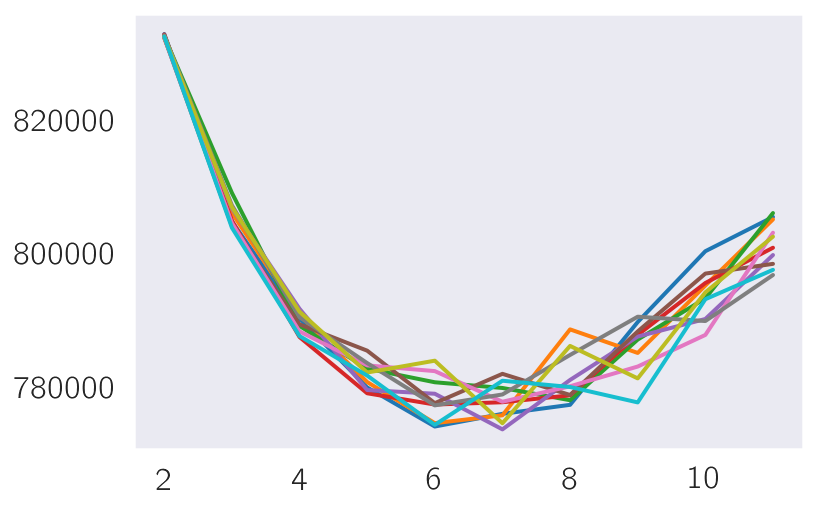

In [50]:
for j in range(10):
    loss = []
    for i in range(2, 12):
        kmeans = KMeans(n_clusters=i, algorithm='full').fit(train[0])
        loss += [kmeans.inertia_ + 10 ** 3 * i ** 2]
    plt.scatter(range(2, 12), loss)

In [60]:
train, test = generate_train_and_test(logdf)
loss = []
for i in range(2, 6):
    nmf = NMF(i, max_iter=10000, alpha=0.3, init='nndsvd', l1_ratio=0.3)
    W = nmf.fit_transform(train[0])
    loss += [nmf.reconstruction_err_ + i ** 2]

4

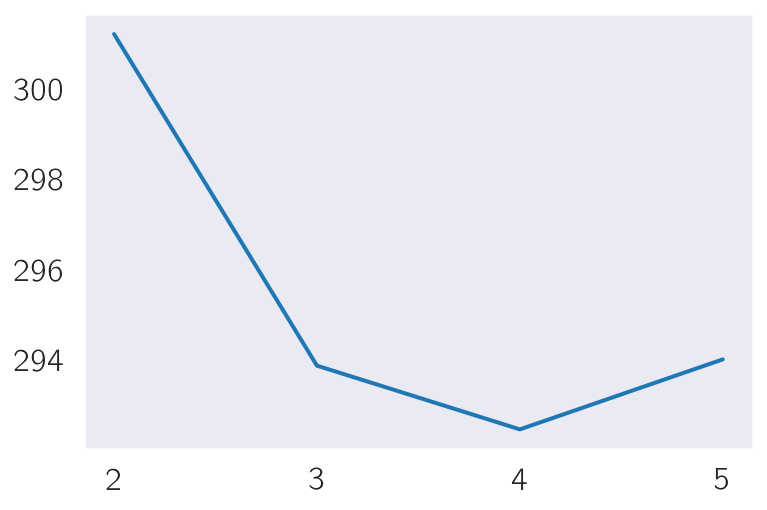

In [62]:
plt.plot(range(2, 6), loss)
range(2, 6)[np.argmin(loss)]